# Recommendations with IBM

In this notebook, you will be putting your recommendation skills to use on real data from the IBM Watson Studio platform. 


You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/rubrics/2322/view).  **Please save regularly.**

By following the table of contents, you will build out a number of different methods for making recommendations that can be used for different situations. 


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations (EXTRA - NOT REQUIRED)](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>

Let's get started by importing the necessary libraries and reading in the data.

In [109]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t
import pickle
import plotly.plotly as py
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.figure_factory as ff

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from matplotlib.cbook import boxplot_stats
from IPython.display import display, display_html

init_notebook_mode(connected = True)
%matplotlib inline
!python --version

df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

# Show df to get an idea of the data
df.head()

Python 3.6.3


,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [110]:
# Show df_content to get an idea of the data
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Use the dictionary and cells below to provide some insight into the descriptive statistics of the data.

`1.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.  

In [111]:
# Print number of unique users and unique articles in data
print('Number of distinct users: {}'.format(df['email'].nunique()))
print('Number of distinct articles: {}'.format(df['article_id'].nunique()))

# Get the number of articles a user interacts with
user_article = df.groupby(['email'], as_index=False).agg({'article_id': ['count', 'nunique']})
user_article.columns = ['email', 'num_articles', 'num_unique_articles']

display(user_article.head())
display(user_article.describe())

Number of distinct users: 5148
Number of distinct articles: 714


,email,num_articles,num_unique_articles
0,0000b6387a0366322d7fbfc6434af145adf7fed1,13,12
1,001055fc0bb67f71e8fa17002342b256a30254cd,4,4
2,00148e4911c7e04eeff8def7bbbdaf1c59c2c621,3,3
3,001a852ecbd6cc12ab77a785efa137b2646505fe,6,5
4,001fc95b90da5c3cb12c501d201a915e4f093290,2,2


,num_articles,num_unique_articles
count,5148.000000,5148.000000
mean,8.930847,6.540210
std,16.802267,9.990676
min,1.000000,1.000000
25%,1.000000,1.000000
50%,3.000000,3.000000
75%,9.000000,7.000000
max,364.000000,135.000000


**The output above tells us the following so far:**
* There are a total of 5148 unique users and 714 unique articles in the dataset.
* Users sometimes access the same article more than once (shown where **num_articles > num_unique_articles**).
* 50% of individuals interact with 3 articles or fewer.
* The maximum number of user-article interactions by any single user is 364 times.

In [112]:
# Plot overall distribution of interactions
fig_box = go.Figure(data=[go.Box(y=user_article['num_articles'],
                             boxpoints='all', # can also be outliers, or suspectedoutliers, or False
                             jitter=0.3, # add some jitter for a better separation between points
                             pointpos=-1.5
                            )],
               layout=go.Layout(yaxis = dict(title = 'Number of Interactions'),
                                xaxis = dict(showticklabels = False),
                                title = 'Distribution of Article Interactions'))
iplot(fig_box)


# Plot count of interactions by each user (granular plot)
data = [dict(
    type = 'bar',
    x = user_article['email'],
    y = user_article['num_articles'],
)]

layout = dict(
    yaxis = dict(title = 'Number of Interactions'),
    xaxis = dict(title = 'Users', automargin = True, showticklabels=False),
    title = 'Number of Article Interactions by User'
)

iplot({'data': data, 'layout': layout}, validate=False) 

**The plots above show the overall distribution of article interactions, specifically the number of times a user interacts with an article. Note two users (i.e. the data points N=363 and N=364 in boxplot) that had substantially more article interactions compared to the rest of the data points, perhaps they are outliers?**

In [113]:
# Take a look at the users with the outlier data points
user_article[user_article['num_articles'] > 200].head()

,email,num_articles,num_unique_articles
910,2b6c0f514c2f2b04ad3c4583407dccd0810469ee,364,135
2426,77959baaa9895a7e2bdc9297f8b27c1b6f2cb52a,363,135


It looks like the two users that accessed the most number of articles have in fact looked at some of the same articles multiple times.

In [114]:
# The median and maximum number of user_article interactios
median_val = 3 # 50% of individuals interact with 3 articles or fewer.
max_views_by_user = 364 # The maximum number of user-article interactions by any single user

`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

In [115]:
# Find and explore duplicate articles
print('\nDuplicate articles:')
display(df_content[df_content.duplicated(['article_id'])])
print('\n\nExample of duplicate article (article_id = 50):')
display(df_content[df_content['article_id']==50].head())


Duplicate articles:


,doc_body,doc_description,doc_full_name,doc_status,article_id
365,Follow Sign in / Sign up Home About Insight Da...,During the seven-week Insight Data Engineering...,Graph-based machine learning,Live,50
692,Homepage Follow Sign in / Sign up Homepage * H...,One of the earliest documented catalogs was co...,How smart catalogs can turn the big data flood...,Live,221
761,Homepage Follow Sign in Get started Homepage *...,Today’s world of data science leverages data f...,Using Apache Spark as a parallel processing fr...,Live,398
970,This video shows you how to construct queries ...,This video shows you how to construct queries ...,Use the Primary Index,Live,577
971,Homepage Follow Sign in Get started * Home\r\n...,"If you are like most data scientists, you are ...",Self-service data preparation with IBM Data Re...,Live,232




Example of duplicate article (article_id = 50):


,doc_body,doc_description,doc_full_name,doc_status,article_id
50,Follow Sign in / Sign up Home About Insight Da...,Community Detection at Scale,Graph-based machine learning,Live,50
365,Follow Sign in / Sign up Home About Insight Da...,During the seven-week Insight Data Engineering...,Graph-based machine learning,Live,50


In [116]:
# Remove any rows that have the same article_id - only keep the first
print('Number of unique articles before removing duplicates: {}'.format(df_content.shape[0]))
df_content = df_content.drop_duplicates(subset=['article_id'], keep='first')
print('Number of unique articles after removing duplicates: {}'.format(df_content.shape[0]))

Number of unique articles before removing duplicates: 1056
Number of unique articles after removing duplicates: 1051


`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [117]:
print('Number of unique articles that have at least one interaction: {}'.format(df['article_id'].nunique()))
print('Number of unique articles on the IBM platform: {}'.format(df_content['article_id'].nunique()))
print('Number of unique users: {}'.format(df['email'].nunique()))
print('Number of user-article interactions: {}'.format(df.shape[0]))

Number of unique articles that have at least one interaction: 714
Number of unique articles on the IBM platform: 1051
Number of unique users: 5148
Number of user-article interactions: 45993


In [118]:
unique_articles = 714 # The number of unique articles that have at least one interaction
total_articles = 1051 # The number of unique articles on the IBM platform
unique_users = 5148 # The number of unique users
user_article_interactions = 45993 # The number of user-article interactions

`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [119]:
# Most viewed article
df['article_id'].value_counts().head(1)

1429.0    937
Name: article_id, dtype: int64

In [120]:
most_viewed_article_id = '1429.0' # The most viewed article in the dataset as a string with one value following the decimal 
max_views = 937 # The most viewed article in the dataset was viewed how many times?

In [121]:
## No need to change the code here - this will be helpful for later parts of the notebook
# Run this cell to map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [122]:
## If you stored all your results in the variable names above, 
## you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

Unlike in the earlier lessons, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.

In [123]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    top_n = df['article_id'].value_counts().index[:n]
    top_articles = []
    for i in range(n):
        article_title = df[df['article_id'] == top_n[i]]['title'].iloc[0]
        top_articles.append(article_title)
    
    return top_articles # Return the top article titles from df (not df_content)

def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    top_articles = df['article_id'].value_counts().index[:n].tolist()
 
    return top_articles # Return the top article ids

In [124]:
print(get_top_articles(10))
print(get_top_article_ids(10))

['use deep learning for image classification', 'insights from new york car accident reports', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'healthcare python streaming application demo', 'finding optimal locations of new store using decision optimization', 'apache spark lab, part 1: basic concepts', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model']
[1429.0, 1330.0, 1431.0, 1427.0, 1364.0, 1314.0, 1293.0, 1170.0, 1162.0, 1304.0]


In [125]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

Use the tests to make sure the basic structure of your matrix matches what is expected by the solution.

In [126]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    user_item = df.groupby(['user_id', 'article_id'])['article_id'].count().unstack().fillna(0)
    for col in user_item.columns.values:
        user_item[col] = user_item[col].apply(lambda x: x if x == 0 else 1)
    
    return user_item # return the user_item matrix 

user_item = create_user_item_matrix(df)

In [127]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


`2.` Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

Use the tests to test your function.

In [128]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''
    # Compute similarity of each user to the provided user
    similarity = user_item[user_item.index == user_id].dot(user_item.T)
    # Create list of just the ids sorted by similarity
    most_similar_users = similarity.sort_values(user_id, axis=1, ascending=False).columns.tolist()
    # Remove the own user's id
    most_similar_users.remove(user_id)
    
    return most_similar_users # return a list of the users in order from most to least similar
        

In [129]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933, 23, 3782, 203, 4459, 3870, 131, 4201, 46, 5041]
The 5 most similar users to user 3933 are: [1, 23, 3782, 203, 4459]
The 3 most similar users to user 46 are: [4201, 3782, 23]


`3.` Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend.  Complete the functions below to return the articles you would recommend to each user. 

In [130]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    article_names = list(df.loc[df['article_id'].isin(article_ids),'title'].unique())
    
    return article_names # Return the article names associated with list of article ids


def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    article_ids = user_item.loc[user_id][list(user_item.loc[user_id] == 1)].index.astype(str)
    article_names = get_article_names(article_ids)
    
    return article_ids, article_names # return the ids and names


def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    recs = []
    most_similar_users = find_similar_users(user_id, user_item=user_item)
    user_article_ids, user_article_names = get_user_articles(user_id)
    for user_id in most_similar_users:
        if len(recs) < m:
            similar_article_ids, similar_article_names = get_user_articles(user_id)
            recs = list(set().union(recs, similar_article_ids)) 
        else:
            break
    
    recs = recs[:m]
    
    return recs # return your recommendations for this user_id    

In [131]:
# Check Results
get_article_names(user_user_recs(1, 10)) # Return 10 recommendations for user 1

['visualize car data with brunel',
 'use xgboost, scikit-learn & ibm watson machine learning apis',
 'uci ml repository: chronic kidney disease data set',
 'sector correlations shiny app',
 'shiny: a data scientist’s best friend',
 'country statistics: life expectancy at birth',
 'introduction to market basket analysis in\xa0python',
 'categorize urban density',
 'python for loops explained (python for data science basics #5)',
 'predict loan applicant behavior with tensorflow neural networking']

In [132]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set(['1320.0', '232.0', '844.0'])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [133]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
             
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    neighbors_df = pd.DataFrame(columns=['neighbor_id','similarity','num_interactions'])
    
    for i in user_item.index.values:
        if i == user_id:
            continue
        neighbor_id = i
        # Compute user similarity
        similarity = user_item[user_item.index == user_id].dot(user_item.loc[i].T).values[0]
        num_interactions = user_item.loc[i].values.sum()
        neighbors_df.loc[neighbor_id] = [neighbor_id, similarity, num_interactions]
        
    neighbors_df['similarity'] = neighbors_df['similarity'].astype('int')
    neighbors_df['neighbor_id'] = neighbors_df['neighbor_id'].astype('int')
    neighbors_df = neighbors_df.sort_values(by = ['similarity', 'neighbor_id'], ascending = [False, True])

    return neighbors_df # Return the dataframe specified in the doc_string
    
    
def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''
    top_articles = get_top_article_ids(unique_articles) #floats
    top_articles = [str(i) for i in top_articles]
    
    top_users = get_top_sorted_users(user_id, user_item=user_item)
    user_article_ids, user_article_names = get_user_articles(user_id) #strings
    recs = np.array([])
    
    for uid in top_users['neighbor_id']:
        if len(recs) < m:
            similar_article_ids, similar_article_names = get_user_articles(uid) #strings
            new_recs = np.setdiff1d(similar_article_ids, user_article_ids, assume_unique=True)
            new_recs = np.intersect1d(top_articles, new_recs)
            recs = np.append(recs, new_recs)            
            recs = np.unique(recs)
        else:
            break  
            
    recs = recs[:m]        
    rec_names = get_article_names(recs)
    
    return recs, rec_names

In [134]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
['1006.0' '1035.0' '109.0' '111.0' '112.0' '1154.0' '1160.0' '1162.0'
 '1165.0' '1172.0']

The top 10 recommendations for user 20 are the following article names:
['analyze energy consumption in buildings', 'apache spark lab, part 3: machine learning', 'analyze precipitation data', 'analyze accident reports on amazon emr spark', 'tidy up your jupyter notebooks with scripts', 'tensorflow quick tips', 'airbnb data for analytics: vienna listings', 'machine learning for the enterprise.', 'essentials of machine learning algorithms (with python and r codes)', 'building custom machine learning algorithms with apache systemml']


`5.` Use your functions from above to correctly fill in the solutions to the dictionary below.  Then test your dictionary against the solution.  Provide the code you need to answer each following the comments below.

In [135]:
### Tests with a dictionary of results
user1_most_sim = get_top_sorted_users(1)['neighbor_id'].iloc[0] # Find the user that is most similar to user 1 
user131_10th_sim = get_top_sorted_users(131)['neighbor_id'].iloc[9] # Find the 10th most similar user to user 131

print('Top 5 users most similar to user 1:')
display(get_top_sorted_users(1).head(5))
print('- user {} is most similar to user 1'.format(user1_most_sim))
print('\n---------------------------------------')
print('\nTop 10 users most similar to user 131:')
display(get_top_sorted_users(131).head(10))
print('- user {} is the 10th most similar to user 131'.format(user131_10th_sim))

Top 5 users most similar to user 1:


,neighbor_id,similarity,num_interactions
3933,3933,35,35.0
23,23,17,135.0
3782,3782,17,135.0
203,203,15,96.0
4459,4459,15,96.0


- user 3933 is most similar to user 1

---------------------------------------

Top 10 users most similar to user 131:


,neighbor_id,similarity,num_interactions
3870,3870,74,75.0
3782,3782,39,135.0
23,23,38,135.0
203,203,33,96.0
4459,4459,33,96.0
49,49,29,101.0
98,98,29,97.0
3697,3697,29,100.0
3764,3764,29,97.0
242,242,25,59.0


- user 242 is the 10th most similar to user 131


In [136]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.

**From the functions/approaches above, we would (to an extent) be able to make new recommendations using the rank based approach i.e. the `get_top_article_ids()` function.  Again, in these cases, the popularity of an article is based on how often it is interacted with. The downside to this approach is that the recommendations are purely based on the most viewed articles with respect to the *whole readership community*, which does not necessarily mean they are the most relevant/interesting to any specific user (since the recommendations are generalized w.r.t the whole universal set!).**

**The problem with the user-user approach is that it is dependant on existent user activity (i.e. interactions with articles) to be able to make any recommendations. In other words, if a new user hasn't interacted with any articles yet, this approach is of no use since there is no information to go off of to make any actual recommendations (all similarities would be 0).**

**A potentially better way to make recommendations to new users is to use content based or knowledge based recommendation engines where the system has implicit (e.g. user clicks) and explicit knowledge of a user's profile, their preferences, recommendation criteria, article attributes, etc. in order to make more personalized recommendations that are relevant to that specific user.**  
* **Since there are limitations/caveats to each approach (e.g. content based recommendation engines are weak at capturing inter-dependencies or complex behaviors), another viable solution to improve recommendations would be to use a hybrid of different approaches. For instance, you could use both content-based *and* collaborative filtering to take advantage of both the representation of the content as well as the similarities across users in order to improve recommendations.**


`7.` Using your existing functions, provide the top 10 recommended articles you would provide for the a new user below.  You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

In [137]:
new_user = '0.0'

# What would your recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 
new_user_recs = get_top_article_ids(10) # Recommendations
new_user_recs = [str(i) for i in new_user_recs]
print(new_user_recs)

['1429.0', '1330.0', '1431.0', '1427.0', '1364.0', '1314.0', '1293.0', '1170.0', '1162.0', '1304.0']


In [138]:
assert set(new_user_recs) == set(['1314.0','1429.0','1293.0','1427.0','1162.0','1364.0','1304.0','1170.0','1431.0','1330.0']), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Content-Recs">Part IV: Content Based Recommendations (EXTRA - NOT REQUIRED)</a> - SKIPPED due to time constraints, will followup on later date.

Another method we might use to make recommendations is to perform a ranking of the highest ranked articles associated with some term.  You might consider content to be the **doc_body**, **doc_description**, or **doc_full_name**.  There isn't one way to create a content based recommendation, especially considering that each of these columns hold content related information.  

`1.` Use the function body below to create a content based recommender.  Since there isn't one right answer for this recommendation tactic, no test functions are provided.  Feel free to change the function inputs if you decide you want to try a method that requires more input values.  The input values are currently set with one idea in mind that you may use to make content based recommendations.  One additional idea is that you might want to choose the most popular recommendations that meet your 'content criteria', but again, there is a lot of flexibility in how you might make these recommendations.

In [139]:
def make_content_recs():
    '''
    INPUT:
    
    OUTPUT:
    
    '''

`2.` Now that you have put together your content-based recommendation system, use the cell below to write a summary explaining how your content based recommender works.  Do you see any possible improvements that could be made to your function?  Is there anything novel about your content based recommender?

**Write an explanation of your content based recommendation system here.**

`3.` Use your content-recommendation system to make recommendations for the below scenarios based on the comments.  Again no tests are provided here, because there isn't one right answer that could be used to find these content based recommendations.

In [140]:
# make recommendations for a brand new user


# make a recommendations for a user who only has interacted with article id '1427.0'



### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, you will build use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`1.` You should have already created a **user_item** matrix above in **question 1** of **Part III** above.  This first question here will just require that you run the cells to get things set up for the rest of **Part V** of the notebook. 

In [141]:
# Load the matrix here
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [142]:
# quick look at the matrix
user_item_matrix.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


`2.` In this situation, you can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  Use the cell to perform SVD, and explain why this is different than in the lesson.

In [143]:
# Perform SVD on the User-Item Matrix Here
u, s, vt = np.linalg.svd(user_item_matrix)

**In this case, we can use SVD since our user_item_matrix has no missing values (unlike what we saw in the lesson where we had a sparse matrix containing nulls and thus used FunkSVD). Recall that SVD does not converge when there are nulls in the matrix, whereas FunkSVD ignores the nulls and still computes the latent features based just on the known values, hence the difference.**

`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

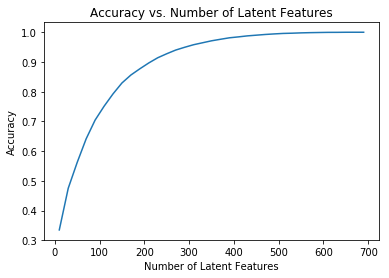

In [144]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

Use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [145]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    user_item_train = create_user_item_matrix(df_train)
    user_item_test = create_user_item_matrix(df_test)
    test_idx = user_item_test.index.unique().tolist()
    test_arts = user_item_test.columns.unique().tolist()
    
    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

In [146]:
q1 = len(np.intersect1d(df_train['user_id'].unique(), df_test['user_id'].unique()))
q2 = len(df_test['user_id'].unique()) - len(np.intersect1d(df_train['user_id'].unique(), df_test['user_id'].unique()))
q3 = len(np.intersect1d(df_train['article_id'].unique(), df_test['article_id'].unique()))
q4 = len(df_test['article_id'].unique()) - len(np.intersect1d(df_train['article_id'].unique(), df_test['article_id'].unique()))

print('How many users can we make predictions for in the test set?\n- Answer: ', q1)
print('How many users in the test set are we not able to make predictions for because of the cold start problem?\n- Answer: ', q2)
print('How many articles can we make predictions for in the test set?\n- Answer:', q3)
print('How many articles in the test set are we not able to make predictions for because of the cold start problem?\n- Answer: ', q4)

How many users can we make predictions for in the test set?
- Answer:  20
How many users in the test set are we not able to make predictions for because of the cold start problem?
- Answer:  662
How many articles can we make predictions for in the test set?
- Answer: 574
How many articles in the test set are we not able to make predictions for because of the cold start problem?
- Answer:  0


In [147]:
# Replace the values in the dictionary below
a = 662 
b = 574 
c = 20 
d = 0 

sol_4_dict = {
    'How many users can we make predictions for in the test set?': c, 
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': a, 
    'How many articles can we make predictions for in the test set?': b,
    'How many articles in the test set are we not able to make predictions for because of the cold start problem?': d
}

t.sol_4_test(sol_4_dict)

Awesome job!  That's right!  All of the test articles are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


`5.` Now use the **user_item_train** dataset from above to find U, S, and V transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

Use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  

In [148]:
# Fit SVD on the user_item_train matrix
u_train, s_train, vt_train = np.linalg.svd(user_item_train)

In [149]:
# Find the subset of rows in the user_item_test dataset that can be predicted:
# get users and articles in train set 
train_idx = np.array(user_item_train.index)
train_arts = np.array(user_item_train.columns)

# get users and articles that are in BOTH train and test sets
test_user_subset = np.intersect1d(test_idx, train_idx)
test_articles_subset = np.intersect1d(test_arts, train_arts)

# get the position of the test subset (user id, article id) in the training matrix 
train_indexes = np.where(np.in1d(train_idx, test_user_subset))[0]
train_articles = np.where(np.in1d(train_arts, test_articles_subset))[0]
# get the position of the test subset (user id) in the test matrix
test_indexes = np.where(np.in1d(test_idx, test_user_subset))[0]

# get the subset
user_item_test_subset = user_item_test.iloc[test_indexes, :]

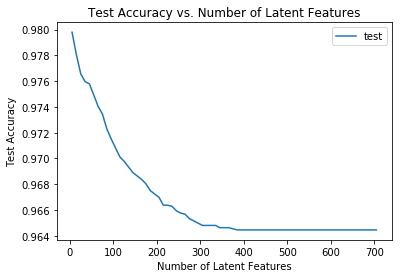

In [150]:
# Test model
num_latent_feats = np.arange(5,715,10)
sum_errs = []

# Loop through different numbers of latent features
for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s_train[:k]), u_train[:, :k], vt_train[:k, :]
    s_test, u_test, vt_test = s_new, u_new[train_indexes,:], vt_new[:, train_articles]
    
    # take dot product
    user_item_subset_est = np.around(np.dot(np.dot(u_test, s_test), vt_test))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_test_subset, user_item_subset_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
# Plot
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/user_item_subset_est.size, label= 'test')
plt.xlabel('Number of Latent Features')
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy vs. Number of Latent Features')
plt.legend();

`6.` Use the cell below to comment on the results you found in the previous question. Given the circumstances of your results, discuss what you might do to determine if the recommendations you make with any of the above recommendation systems are an improvement to how users currently find articles? 

**The results on the test set show that the prediction accuracy decreases as the number of latent features increases and then hits a baseline accuracy regardless of adding more features. This is due to the fact that we are only predicting for 20 users (those who were in both the training and test sets), which is not enough to actually represent how well our SVD works towards making predictions for recommendations on the test data. And the reason that the accuracy is so highe is due to the substantial class imbalance of 1's and 0's.**

**Given these findings, we can try an alternative approach where instead of performing offline testing as we did here, we can instead implement online testing by evaluating user behavior via hypothesis testing. For instance, we can perform an A/B test by splitting the user base such that one half of randomly selected users is served articles via the current way (the control group) and the other half is simultaneously served articles by one (or a hybrid) of our recommendation systems above (the test group), and then analyze the click-through-rates (the key metric) for each group to see if applying a recommendation system actually increases CTR. Our hypothesis setup would be something like:**
* **Null hypothesis = "there is no increase in CTR (when applying our recommendation system)"**   
* **Alternative hypothesis = "there is an increase in CTR (when applying our recommendation system)"**

**Once we choose an appropriate significance level, sample size and time duration of the test, and let the test run, we can then analyze the results to determine whether there is a statistically significant increase (i.e. the p-value is less than alpha) in CTR when applying our recommendation system or not. This will help us to determine if using our recommendations system is indeed an improvement to how users are currently finding articles.**

In [151]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Recommendations_with_IBM.ipynb'])

0